# Named Entity Recognition CharLevel-BiLSTM

Named Enity Recognition is one of the most common NLP problems. The goal is classify named entities in text into pre-defined categories such as the names of persons, organizations, locations, expressions of times, quantities, monetary values, percentages, etc. What can you use it for? Here are a few ideas - social media, chatbot, customer support tickets, survey responses, and data mining!

Enhancing LSTMs with character embeddings for Named entity recognition

Let's start by importing some packages.

In [1]:
files_path = "./"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers

# Training Parameters
We'll set the hyperparameters for training our model.

In [3]:
# Hyperparams if GPU is available
if len(tf.config.list_physical_devices('GPU')) > 0:
    BATCH_SIZE = 512  # Number of examples used in each iteration
    EPOCHS = 5  # Number of passes through entire dataset
    MAX_LEN = 75  # Max length of review (in words)
    MAX_LEN_CHAR = 10
    EMBEDDING = 40  # Dimension of word embedding vector

    
# Hyperparams for CPU training
else:
    BATCH_SIZE = 32
    EPOCHS = 5
    MAX_LEN = 75
    MAX_LEN_CHAR = 10
    EMBEDDING = 20

# Data

Let's take a look at data. [Annotated Corpus for Named Entity Recognition](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus?select=ner_dataset.csv)

In [4]:
data = pd.read_csv(f"{files_path}ner_dataset.csv", encoding="latin1")
data = data.fillna(method="ffill")

print("Number of sentences: ", len(data.groupby(['Sentence #'])))

words = list(set(data["Word"].values))
n_words = len(words)
print("Number of words in the dataset: ", n_words)

tags = list(set(data["Tag"].values))
print("Tags:", tags)
n_tags = len(tags)
print("Number of Labels: ", n_tags)

print("What the dataset looks like:")
# Show the first 10 rows
data.head(n=10)

Number of sentences:  47959
Number of words in the dataset:  35178
Tags: ['O', 'B-gpe', 'B-org', 'I-org', 'I-geo', 'B-geo', 'B-nat', 'I-gpe', 'B-eve', 'I-art', 'I-per', 'B-art', 'I-eve', 'I-nat', 'B-per', 'B-tim', 'I-tim']
Number of Labels:  17
What the dataset looks like:


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [5]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None
        
getter = SentenceGetter(data)
sent = getter.get_next()
print('This is what a sentence looks like:')
print(sent)

This is what a sentence looks like:
[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


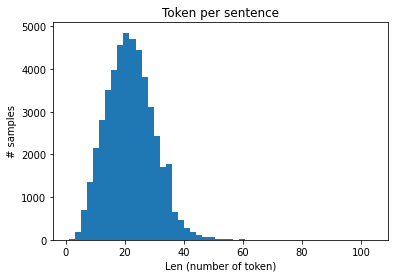

In [6]:
# Get all the sentences
sentences = getter.sentences

# Plot sentence by lenght
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

# Data Preprocessing
Before feeding the data into the model, we have to preprocess the text.

* We will use the word2idx dictionary to convert each word to a corresponding integer ID and the tag2idx to do the same for the labels. Representing words as integers saves a lot of memory!
* In order to feed the text into our Bi-LSTM-CRF, all texts should be the same length. We ensure this using the sequence.pad_sequences() method and MAX_LEN variable. All texts longer than MAX_LEN are truncated and shorter texts are padded to get them to the same length.
The *Tokens per sentence* plot (see above) is useful for setting the MAX_LEN training hyperparameter.

In [7]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding

# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}

# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0

# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}

print("The word Obama is identified by the index: {}".format(word2idx["Obama"]))
print("The labels B-geo(which defines Geopraphical Enitities) is identified by the index: {}".format(tag2idx["B-geo"]))


from keras.preprocessing.sequence import pad_sequences
# Convert each sentence from list of Token to list of word_index
X_word = [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X_word = pad_sequences(maxlen=MAX_LEN, sequences=X_word, padding="post", value=word2idx["PAD"],truncating='post')

# Get unique characters from sentences
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)

# Convert each char from list of Token to list of character_index
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["PAD"] = 0

X_char = []
for sentence in sentences:
    sent_seq = []
    for i in range(MAX_LEN):
        word_seq = []
        for j in range(MAX_LEN_CHAR):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))

# Convert Tag/Label to tag_index
y = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y = pad_sequences(maxlen=MAX_LEN, sequences=y, padding="post", value=tag2idx["PAD"],truncating='post')

#from keras.utils import to_categorical
# One-Hot encode
# y = [to_categorical(i, num_classes=n_tags+1) for i in y]  # n_tags+1(PAD)

from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.1, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.1, random_state=2018)

print('Raw Sample: ', ' '.join([w[0] for w in sentences[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences[0]]))
print('After processing, sample:', X_word[0])
print('After processing, labels:', y[0])

The word Obama is identified by the index: 31194
The labels B-geo(which defines Geopraphical Enitities) is identified by the index: 6


Using TensorFlow backend.


Raw Sample:  Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .
Raw Label:  O O O O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O
After processing, sample: [28150  3955  2424 22495 15989 22828 11375 33551 21142  2236 24716 31267
  5781 31295 10725  2236 18747  3955 33831 22529 29338  5497 11912 20178
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
After processing, labels: [1 1 1 1 1 1 6 1 1 1 1 1 6 1 1 1 1 1 2 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0]


# Model
The trick here is, to wrap the parts that should be applied to the characters in a TimeDistributed layer to apply the same layers to every character sequence.

In [8]:
# Get CRF layer for Tensroflow 2.x
# ! pip install tf2crf
# ! pip install sklearn-crfsuite

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,LSTM, Embedding, Dense, TimeDistributed, Dropout
from tensorflow.keras.layers import Conv1D, Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

In [10]:
# input and embedding for words
word_in = Input(shape=(MAX_LEN,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=20,
                     input_length=MAX_LEN, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(MAX_LEN, MAX_LEN_CHAR,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=10,
                           input_length=MAX_LEN_CHAR, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(LSTM(units=20, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(LSTM(units=50, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 10)]     0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 75)]         0                                            
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 75, 10, 10)   1000        input_2[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 75, 20)       703600      input_1[0][0]                    
______________________________________________________________________________________________

# Training & Evaluate
*Note:* Accuracy isn't the best metric to choose for evaluating this type of task because most of the time it will correctly predict **'O'** or **'PAD'** without identifing the important Tags, which are the ones we are interested in. So after training for some epochs, we can monitor the **precision**, **recall** and **f1-score** for each of the Tags.

In [11]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), MAX_LEN, MAX_LEN_CHAR))],
                    np.array(y_tr).reshape(len(y_tr), MAX_LEN, 1),
                    batch_size=128, epochs=10, validation_split=0.1, verbose=1)

Epoch 1/10
304/304 [==============================] - 272s 893ms/step - loss: 0.2723 - acc: 0.2480 - val_loss: 0.1440 - val_acc: 0.2458
Epoch 2/10
304/304 [==============================] - 270s 889ms/step - loss: 0.1133 - acc: 0.2468 - val_loss: 0.0967 - val_acc: 0.2458
Epoch 3/10
304/304 [==============================] - 270s 889ms/step - loss: 0.0900 - acc: 0.2478 - val_loss: 0.0813 - val_acc: 0.2563
Epoch 4/10
304/304 [==============================] - 267s 878ms/step - loss: 0.0579 - acc: 0.2745 - val_loss: 0.0451 - val_acc: 0.2777
Epoch 5/10
304/304 [==============================] - 273s 898ms/step - loss: 0.0399 - acc: 0.2806 - val_loss: 0.0383 - val_acc: 0.2794
Epoch 6/10
304/304 [==============================] - 269s 886ms/step - loss: 0.0341 - acc: 0.2819 - val_loss: 0.0358 - val_acc: 0.2799
Epoch 7/10
304/304 [==============================] - 269s 885ms/step - loss: 0.0310 - acc: 0.2826 - val_loss: 0.0347 - val_acc: 0.2801
Epoch 8/10
304/304 [============================

In [12]:
hist = pd.DataFrame(history.history)

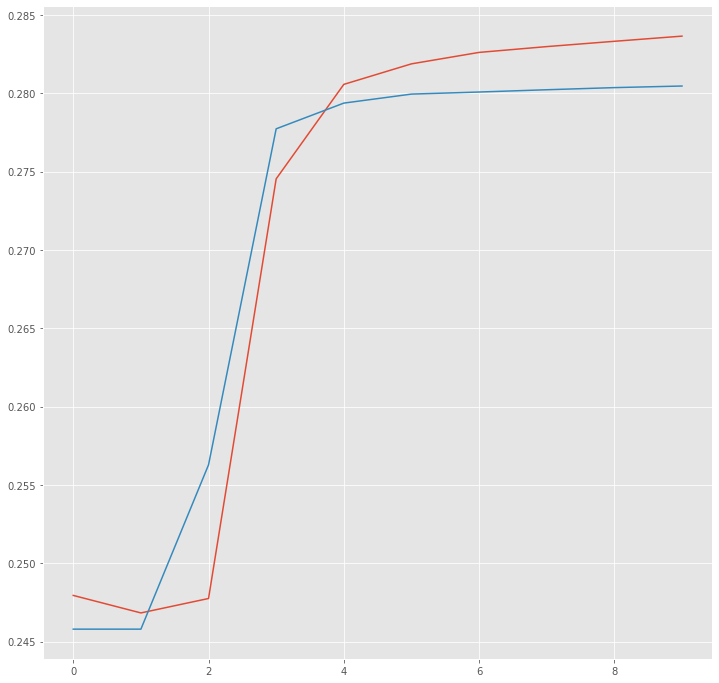

In [14]:
plt.style.use("ggplot")
plt.figure(figsize=(12, 12))
plt.plot(hist["acc"])
plt.plot(hist["val_acc"])
plt.show()

In [19]:
# Eval
y_pred = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     MAX_LEN, MAX_LEN_CHAR))])

In [20]:
i = 1925
p = np.argmax(y_pred[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_word_te[i], y_te[i], p):
    if w != 0:
        print("{:15}: {:5} {}".format(idx2word[w], idx2tag[t], idx2tag[pred]))

Word           ||True ||Pred
On             : O     O
Monday         : B-tim B-tim
,              : O     O
British        : B-org B-gpe
Foreign        : I-org O
Secretary      : B-per O
Jack           : I-per I-per
Straw          : I-per I-per
said           : O     O
his            : O     O
government     : O     O
has            : O     O
found          : O     O
no             : O     O
evidence       : O     O
the            : O     O
Bush           : B-org B-geo
administration : O     O
requested      : O     O
permission     : O     O
to             : O     O
fly            : O     O
terror         : O     O
suspects       : O     O
through        : O     O
Britain        : B-geo B-geo
or             : O     O
its            : O     O
airspace       : O     O
.              : O     O


# Save the result

In [ ]:
import pickle

# Saving Vocab
with open('models/word_to_index.pickle', 'wb') as handle:
    pickle.dump(word2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Vocab
with open('models/tag_to_index.pickle', 'wb') as handle:
    pickle.dump(tag2idx, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Saving Model Weight
model.save_weights('models/lstm_crf_weights.h5')

# References

[Build a deep learning model for predicting the named entities from text.](https://github.com/floydhub/named-entity-recognition-template)

[Bidirectional LSTM-CRF Models for Sequence Tagging](https://arxiv.org/pdf/1508.01991v1.pdf)

[Enhancing LSTMs with character embeddings for Named entity recognition](https://www.depends-on-the-definition.com/lstm-with-char-embeddings-for-ner/)
